In [1]:
import os
import sys

# os.path.join(os.path.dirname(__file__)
sys.path.append("../")  # location of config file
sys.path.append("../../../") 

import config
import glob
import numpy as np
from smartprint import smartprint as sprint
from preprocessing.ProcessRaw import ProcessRaw
from smartprint import smartprint as sprint

In [2]:
train_file_list = glob.glob("../../../train_data_all_cities/*")

import random
random.shuffle(train_file_list)

In [3]:
len(train_file_list)

3919361

In [4]:
#############################################
##### Standard method using numpy files #####
#############################################


from tqdm import tqdm



print ( "time reading all files of a particular experiment ")

i_o_length = 1
pred_horiz = 1
scale = 191
city = "london"

prefix = ProcessRaw.file_prefix(city, i_o_length, pred_horiz, scale)
sprint (prefix)
filename_filtered = [x for x in train_file_list if prefix in x and "_x" in x]
sprint (filename_filtered[:5])

sprint (len(filename_filtered))
for _, filename in tqdm(enumerate(filename_filtered)):
    m = np.load(filename)
    if np.random.rand() < 0.001:
        print (m.shape)

time reading all files of a particular experiment 
prefix : london-1-1-191-
List: filename_filtered[:5]


[
    '../../../train_data_all_cities/london-1-1-191-10618_x.npy',
    '../../../train_data_all_cities/london-1-1-191-5934_x.npy',
    '../../../train_data_all_cities/london-1-1-191-8028_x.npy',
    '../../../train_data_all_cities/london-1-1-191-11644_x.npy',
    '../../../train_data_all_cities/london-1-1-191-1952_x.npy'
]

len(filename_filtered) : 16560


406it [00:00, 4059.11it/s]

(191, 191, 1)


2477it [00:00, 4144.74it/s]

(191, 191, 1)
(191, 191, 1)


3730it [00:00, 4162.05it/s]

(191, 191, 1)


4983it [00:01, 4157.19it/s]

(191, 191, 1)


6235it [00:01, 4153.57it/s]

(191, 191, 1)
(191, 191, 1)
(191, 191, 1)


7069it [00:01, 4155.26it/s]

(191, 191, 1)


9161it [00:02, 4175.44it/s]

(191, 191, 1)
(191, 191, 1)


10415it [00:02, 4165.07it/s]

(191, 191, 1)
(191, 191, 1)
(191, 191, 1)


11249it [00:02, 4121.62it/s]

(191, 191, 1)


12909it [00:03, 4143.74it/s]

(191, 191, 1)
(191, 191, 1)


14989it [00:03, 4145.67it/s]

(191, 191, 1)
(191, 191, 1)
(191, 191, 1)


16560it [00:03, 4142.63it/s]

(191, 191, 1)


In [5]:
import os
import shutil
import numpy as np


#############################################
##### Standard method using numpy files #####
##### Using a smaller folder size       #####
#############################################

# List of filenames
filenames = list(filename_filtered)

# Create temporary folder
temp_folder = '/home/niskumar/temp'
os.makedirs(temp_folder, exist_ok=True)

filenames = [x.split("../../../train_data_all_cities/")[1] for x in filenames]

# Copy files to temporary folder
for i, filename in enumerate(filename_filtered):
    src = filename  # using the longer filename
    dst = os.path.join(temp_folder, filenames[i]) # using the shorter name in dst
    shutil.copy(src, dst)

# Load files using numpy
loaded_files = []
for _, filename in tqdm(enumerate(filenames)):
    file_path = os.path.join(temp_folder, filename)
    loaded_file = np.load(file_path)
    # loaded_files.append(loaded_file)

# Delete temporary folder
shutil.rmtree(temp_folder)


16560it [00:03, 4283.28it/s]


In [6]:

##############################################################################################################
##### Using compressed arrays (CSR format) files #############################################################
##### Also comparing that the operation gives the same value on expanded vs compressed arrays ################
##############################################################################################################


import os
import shutil
import numpy as np
from scipy import sparse
import pickle

# List of filenames
filenames = list(filename_filtered)

# Create temporary folder
temp_folder = '/home/niskumar/temp'
os.makedirs(temp_folder, exist_ok=True)

filenames = [x.split("../../../train_data_all_cities/")[1] for x in filenames]

# Copy files to temporary folder
for i, filename in tqdm(enumerate(filename_filtered), desc="Creating sparse files"):
    src = filename
    dst = os.path.join(temp_folder, filenames[i])
    m = np.load(src).flatten()
    # print (m.shape)
    sparse_m = sparse.csr_matrix(m) 
    file = open(dst + ".pickle",'wb') #160kb
    pickle.dump(sparse_m, file)

    

# Load files using numpy
loaded_files = []
for runs in range(1):
    for i, filename in tqdm(enumerate(filenames), "Using sparse single iteration"):
        file_path = os.path.join(temp_folder, filename)
        dst = os.path.join(temp_folder, filenames[i]) 
        file = open(dst + ".pickle",'rb') 
        sparse_m = pickle.load(file)
        m = sparse_m.toarray()
        # if np.random.rand() < 0.0001:
        #     print (m.shape)
    
    # loaded_files.append(loaded_file)

# Delete temporary folder
# shutil.rmtree(temp_folder)


for runs in tqdm(enumerate(range(5)), desc="Using sparse, compute both ways"):

    query_matrix = sparse_m.toarray() # just choose the last one
    query_matrix_sparse = sparse_m
        
    for i, filename in (enumerate(filenames)):
        file_path = os.path.join(temp_folder, filename)
        dst = os.path.join(temp_folder, filenames[i]) 
        file = open(dst + ".pickle",'rb') 
        new_mat_sparse = pickle.load(file)
        new_mat = new_mat_sparse.toarray()

        dist_full = np.max(np.abs(query_matrix - new_mat))
        dist_sparse = abs((query_matrix_sparse - new_mat_sparse)).max()
        assert (dist_full == dist_sparse)
        
#         if np.random.rand() < 0.0001:
#             sprint (new_mat.shape, new_mat_sparse.shape)
#             sprint (dist_full)
        
    
for runs in tqdm(enumerate(range(5)), desc="Using sparse, compute only once"):

    # query_matrix = sparse_m.toarray() # just choose the last one
    query_matrix_sparse = sparse_m
        
    for i, filename in (enumerate(filenames)):
        file_path = os.path.join(temp_folder, filename)
        dst = os.path.join(temp_folder, filenames[i]) 
        file = open(dst + ".pickle",'rb') 
        new_mat_sparse = pickle.load(file)
        # new_mat = new_mat_sparse.toarray()

        # dist_full = np.max(np.abs(query_matrix - new_mat))
        dist_sparse = abs((query_matrix_sparse - new_mat_sparse)).max()
        # assert (dist_full == dist_sparse)    

Creating sparse files: 16560it [00:16, 1033.58it/s]
Using sparse single iteration: 16560it [00:00, 20288.08it/s]
Using sparse, compute both ways: 5it [00:27,  5.42s/it]
Using sparse, compute only once: 5it [00:17,  3.51s/it]


In [21]:
# ! pip uninstall torch
# ! pip install torch

##############################################################################################################
##### Using compressed arrays (CSR format) files #############################################################
##### Using a dataloader on top of the compressed format  ####################################################
##### Using 3 threads  #######################################################################################
##############################################################################################################


import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from scipy.spatial import minkowski_distance_p
from tqdm import tqdm
import torch

# def get_file_name_from_int(n, prefix):
#     # query_point_fname = prefix + str(n) + "_x.npy"
#     return query_point_fname

def l_inf_distance(query_point_array, neighbour_x_array):
    mse = torch.max(torch.abs(query_point_array - neighbour_x_array))
    return mse

class FileDataset(Dataset):
    def __init__(self, integer_list, prefix, folderpath):
        self.integer_list = integer_list
        self.prefix = prefix
        # self.folderpath = folderpath

    def __len__(self):
        return len(self.integer_list)

    def __getitem__(self, index):
        integer = self.integer_list[index]
        # filename = get_file_name_from_int(integer, self.prefix)
        dst = os.path.join("/home/niskumar/temp", integer) 
        file = open(dst + ".pickle",'rb') 
        new_mat_sparse = pickle.load(file)
        
        # Standard numpy (commented out below)
        # data = np.load(os.path.join("/home/niskumar/temp", integer))
        # sprint (filename)
        # sprint (torch.from_numpy((new_mat_sparse.to_array())).shape)
        
        return torch.from_numpy(new_mat_sparse.toarray())


def create_distance_matrix(integer_list, prefix, folderpath):
    dataset = FileDataset(integer_list, prefix, folderpath)

    dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=32)

    N = len(integer_list)
    matrix = np.zeros((N, N))

    count_outer = 0
    for i, file1 in (enumerate(dataloader)):
        for j, file2 in tqdm(enumerate(dataloader)):
            file1 = file1# .squeeze()  # Remove batch dimension
            file2 = file2# .squeeze()

            if np.random.rand() < 0.0001:
                sprint (i, j)
            # Assign the mse value to the matrix entry
            matrix[i, j] = l_inf_distance(file1, file2)

        count_outer += 1
        # we compute only for 5 rows of the matrix to get an estimate
        if count_outer >= 5:
            break

    # Return the resulting matrix
    return matrix

distances = create_distance_matrix(filenames, prefix, \
                                                       "../../../train_data_all_cities/")
sprint (distances.shape)

628it [00:00, 883.86it/s] 

i, j : 0 433


3922it [00:03, 1125.56it/s]

i, j : 0 3796


9364it [00:07, 1164.65it/s]

i, j : 0 9220


9968it [00:08, 1120.22it/s]

i, j : 0 9795


16560it [00:13, 1216.69it/s]
13526it [00:10, 1169.55it/s]

i, j : 1 13274


16560it [00:13, 1242.00it/s]
2123it [00:02, 1097.50it/s]

i, j : 2 1894


16560it [00:13, 1252.76it/s]
5019it [00:04, 977.20it/s] 

i, j : 3 4867


16560it [00:14, 1164.14it/s]
8887it [00:07, 1240.86it/s]

i, j : 4 8701


11948it [00:09, 1211.99it/s]

i, j : 4 11756


16560it [00:13, 1264.17it/s]


distances.shape : (16560, 16560)


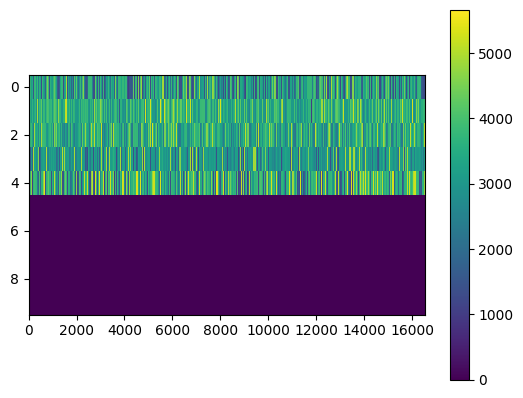

In [22]:
plt.imshow(distances[:10,:], aspect=10000/10, interpolation='none')
plt.colorbar()
plt.show()

In [23]:
# ! pip uninstall torch
# ! pip install torch


##############################################################################################################
##### Using compressed arrays (CSR format) files #############################################################
##### Using a dataloader on top of the UN-compressed npy files  ##############################################
##### Using 3 threads  #######################################################################################
##############################################################################################################


# Pytorch data loader using standard numpy 


import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from scipy.spatial import minkowski_distance_p
from tqdm import tqdm
import torch

def get_file_name_from_int(n, prefix):
    query_point_fname = prefix + str(n) + "_x.npy"
    return query_point_fname

def l_inf_distance(query_point_array, neighbour_x_array):
    # sprint (query_point_array.shape, neighbour_x_array.shape)
    mse = torch.max(torch.abs(query_point_array - neighbour_x_array))
    return mse

class FileDataset(Dataset):
    def __init__(self, integer_list, prefix, folderpath):
        self.integer_list = integer_list
        self.prefix = prefix
        self.folderpath = folderpath

    def __len__(self):
        return len(self.integer_list)

    def __getitem__(self, index):
        integer = self.integer_list[index]
        filename = get_file_name_from_int(integer, self.prefix)
        data = np.load(os.path.join(self.folderpath, filename))
        # sprint (filename)
        return data


def create_distance_matrix(integer_list, prefix, folderpath):
    dataset = FileDataset(integer_list, prefix, folderpath)

    dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=32)

    N = len(integer_list)
    matrix = np.zeros((N, N))

    count_outer = 0
    for i, file1 in (enumerate(dataloader)):
        for j, file2 in tqdm(enumerate(dataloader)):
            file1 = file1# .squeeze()  # Remove batch dimension
            file2 = file2# .squeeze()

            # Assign the mse value to the matrix entry
            matrix[i, j] = l_inf_distance(file1, file2)

        count_outer += 1
        # we compute only for 5 rows of the matrix to get an estimate
        if count_outer >= 5:
            break
            
    # Return the resulting matrix
    return matrix

for city in config.city_list:

    # pred_horiz
    for N in [16000]:
        hist_list = []
        colors = ["#FF0000", "#FF3300", "#FF6600", "#FF9900", "#FFCC00", "#FFFF00", "#CCE600", "#99CC00", "#66B200", "#339900"]
        for scale in config.scales_def:
            for i_o_length in config.i_o_lengths_def:
                for index, pred_horiz in enumerate(config.pred_horiz_def):
                    prefix = ProcessRaw.file_prefix(city, i_o_length, pred_horiz, scale)
                    # sprint (prefix)
                    train_file_list_filtered = [x for x in train_file_list if (prefix in x and "_x.npy" in x)]
                    sprint (len(train_file_list_filtered))
                    
                    file_num_filtered = [int(x.split(prefix)[1].split("_")[0]) for x in train_file_list_filtered]
                    list.sort(file_num_filtered)
                    distances = create_distance_matrix(file_num_filtered, prefix, \
                                                       "../../../train_data_all_cities/")

         

len(train_file_list_filtered) : 16560


16560it [00:11, 1427.18it/s]
16560it [00:10, 1517.84it/s]
16560it [00:11, 1469.87it/s]
16560it [00:10, 1512.29it/s]
16560it [00:11, 1463.63it/s]


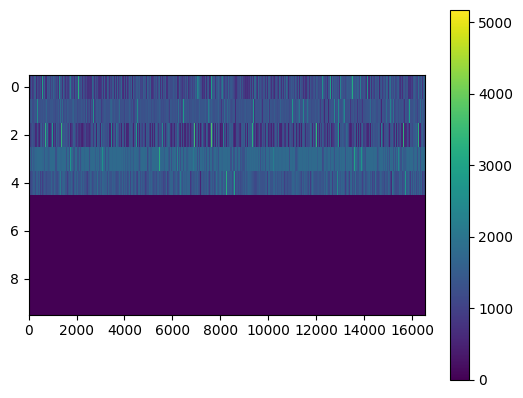

In [24]:
plt.imshow(distances[:10,:], aspect=10000/10, interpolation='none')
plt.colorbar()
plt.show()           